In [7]:
import MS_helper_functions as ms
from meshGen import mesh2DLaminates
import matplotlib.pyplot as plt
%matplotlib widget

import importlib 
importlib.reload(ms)
numSheets = 3
D = 0.04
d = 0.02
ff = 0.7
numSheets = 4
maxh_edges = d/numSheets*1/2 * 0.1
cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=True, modelHalfAir=True, quad_dominated=False)
meshRef = cMeshRef.mesh

modelHalfAir=False
cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="multiscale", maxh_edges=maxh_edges, rotated=True, modelGap=True)
# cMeshMS = mesh2DLaminates(D, d, ff, numSheets, multiscale=True, modelHalfAir=modelHalfAir, domainNameHalfAir="smoothFrame", onlySmooth=onlySmooth)
meshMS = cMeshMS.mesh





maxh_edges [0.00025, 0.00025]
maxh_edges [0.00025, 0.00025]
test multiscale


In [43]:
importlib.reload(ms)
ms.cl_Phi.numSheets = numSheets
ms.cl_Phi.dFe = cMeshMS.dFe
ms.cl_Phi.d0 = cMeshMS.d0
ms.cl_Phi.mesh = meshMS

ms.cl_Phi.modelHalfAir = modelHalfAir
ms.cl_Phi.orientation = 1

orderPhi = [
        ms.cl_Phi(1, 
                    modelHalfAir=False, inAir=True, specialFirstLast=True, 
                    specialFirstLast_func=[lambda x : 0, lambda x:0], 
                    # specialFirstLast_func=[lambda x : 1/ms.cl_Phi.dFe*(x+ms.cl_Phi.dFe/2), lambda x:0], 
                    specialFirstLast_dzfunc=[lambda x : 0, lambda x : 0]), 
    ]

ms.cl_Phi.plotEvaluated(orderPhi)
print(type(orderPhi[0].phi))

a = orderPhi[0]
a.phi
a.modelHalfAir

<function <lambda> at 0x7f04931741f0>


ValueError: Cannot make CoefficientFunction from <function pyPhiFunction.createCFs.<locals>.<lambda> at 0x7f0493300040> of type <class 'function'>

here
here
here


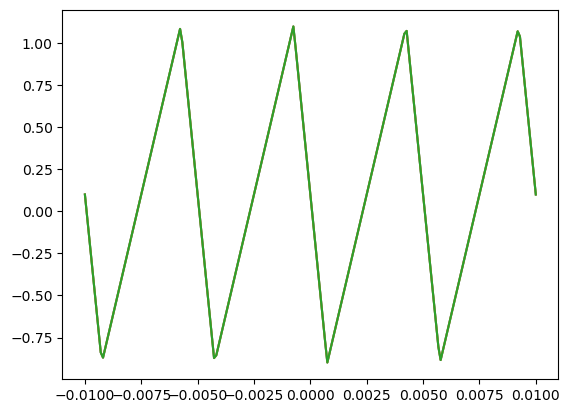

In [9]:
xi = np.linspace(-d/2, d/2, 200)
plt.figure()
for phi in orderPhi:
    yi = [phi.phi.DirectEvaluate(x) + i * 0.5 for x in xi]

    plt.plot(xi, np.array(yi) )
    print("here")


In [5]:
from netgen.occ import *
from ngsolve import *
from netgen.meshing import IdentificationType
from MS_helper_functions import *
from netgen.webgui import Draw as DrawGeo
from ngsolve.webgui import Draw
Draw = lambda *args, **kwargs : None

import matplotlib.pyplot as plt
%matplotlib widget
plt.ioff()

from myPackage import evalOnLine


from meshGen import mesh2DLaminates

D = 0.04
d = 0.02

ff = 0.7


numSheets = 4

maxh_edges = d/numSheets*1/2 * 0.1



rotated = True

cMeshRef = mesh2DLaminates(D, d, ff, numSheets, multiscale=False, maxh_edges=maxh_edges, fullProblemX=True, rotated=rotated, modelHalfAir=False, quad_dominated=False)
meshRef = cMeshRef.mesh
print("Boundaries", set(meshRef.GetBoundaries()))
print("Materials", set(meshRef.GetMaterials()))
Draw(meshRef.ngmesh)

cl_Phi.numSheets = numSheets
cl_Phi.dFe = cMeshRef.dFe
cl_Phi.d0 = cMeshRef.d0
cl_Phi.mesh = meshRef

cl_Phi.modelHalfAir = False
cl_Phi.orientation = 1 if rotated else 0

Boundaries {'ileft', 'itop', 'iright', 'top', 'ibottom', 'right', 'bottom', 'left'}
Materials {'outer', 'inner', 'insulation'}


In [7]:
from ngsolve.webgui import Draw

a = cl_Phi(2, 0).phi.fun[0]
fun_sym_Fe = fun_Fe(x_sym)
dxfun_sym_Fe = diff(fun_sym_Fe)
dxfun_Fe = lambda x : dxfun_sym_Fe.subs([("x", x)])
b = cl_Phi(2, 0).dzphi

Draw(IfPos(x, a, b), meshRef)

ValueError: Cannot make CoefficientFunction from <function pyLobatto.__init__.<locals>.<lambda> at 0x7ff485799fc0> of type <class 'function'>